# Analysis of libjpeg - decompression

**Author:** Martin Beneš

This notebook contains forensic analysis of decompression using various libjpeg versions. Both RGB and grayscale are tested separately. All the other parameters are kept default.

In [13]:
# versions to test
versions = ['6b','turbo210','7','8','8a','8b','8c','8d','9','9a','9b','9c','9d','9e']
versions2 = [v[:min(len(v),5)] for v in versions]

# default versions
import jpeglib
v_arbitrary = '7' # arbitrary version for compression
jpeglib.version.set(v_arbitrary)

# random subsample size
N_samples = 10

# database path
from pathlib import Path
db_path = Path.home() / 'Datasets'

# checkerboard
import numpy as np
def checkerboard(boardsize, tilesize, channels=3):
    board = np.zeros([*boardsize, channels], dtype=np.uint8)
    for i in range(boardsize[0]):
        for j in range(boardsize[1]):
            if (i//tilesize[0]) % 2 == (j//tilesize[1]) % 2:
                board[i,j] = 255
    return board

## Load BOSS

Load BOSSBase database consisting of 10000 grayscale images. It can be downloaded [here](http://agents.fel.cvut.cz/boss/index.php?mode=VIEW&tmpl=materials). For faster execution, we only work with its subsample.

In [14]:
# list BOSS database
import os
boss_path = db_path / 'BOSS_raw' / 'BOSS_from_raw'
boss_names = [boss_path / f for f in os.listdir(boss_path)]
print("Loaded BOSS database with", len(boss_names), "images.")

# sample without replacement
import random
random.seed(42) # answer to everything
boss_names_sub = random.sample(boss_names, N_samples-2)

# choose most and least saturated
#import cv2
#most,least = (None,0),(None,0)
#for i,f in enumerate(boss_names):
#    if i % 500 == 0: print(i, '/', len(boss_names), '         ', end='\r')
#    if str(f).split('.')[-1] != 'png': continue
#    x = cv2.imread(str(f),cv2.IMREAD_GRAYSCALE)
#    xmin,xmax = (x == 0).sum(),(x == 255).sum()
#    if xmin > least[1]: least = (f,xmin)
#    if xmax > most[1]: most = (f,xmax)
most,least = (boss_path / '6900_1_3.png',262144),(boss_path / '6155_1_6.png', 88944)
# add them
boss_names_sub.append(most[0])
boss_names_sub.append(least[0])

# load the grayscale image with cv2
import cv2
boss = np.array([np.array(cv2.imread(str(f),cv2.IMREAD_GRAYSCALE)) for f in boss_names_sub])
boss = np.expand_dims(boss, axis=3)

# append checkerboard
for tilesize in [(4,4),(7,7),(8,8),(15,15),(16,16)]:
    boss = np.append(boss, np.expand_dims(checkerboard((512, 512), tilesize, channels=1), 0), 0)

print("Input shape", boss.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/home/nora/Datasets/BOSS_raw/BOSS_from_raw'

## Load ALASKA

Load ALASKA2 database consisting of 70000 colored images. In this case we have uncompressed version of shape 256x256. You can find the scripts to download it [here](https://alaska.utt.fr/).

In [15]:
# Load ALASKA2 database
import random
alaska_path = db_path / 'ALASKA_v2_TIFF_256_COLOR'
alaska_names = [alaska_path / f for f in os.listdir(alaska_path)]
print("Loaded ALASKA2 database with", len(alaska_names), "images.")

# sample without replacement
random.seed(42) # answer to everything
alaska_names_sub = random.sample(alaska_names, N_samples-2)

# choose most and least saturated
import matplotlib.pyplot as plt
#most,least = (None,0),(None,0)
#for i,f in enumerate(alaska_names):
#    if i % 500 == 0: print(i, '/', len(alaska_names), '         ', end='\r')
#    if str(f).split('.')[-1] != 'tif': continue
#    x = plt.imread(str(f))
#    xmin,xmax = (x == 0).sum(),(x == 255).sum()
#    if xmin > least[1]: least = (f,xmin)
#    if xmax > most[1]: most = (f,xmax)
most,least = (alaska_path / '10343.tif',98491),(alaska_path / '05887.tif', 78128)
# add them
alaska_names_sub.append(most[0])
alaska_names_sub.append(least[0])

# load the image with PIL
import matplotlib.pyplot as plt
alaska = np.array([plt.imread(f) for f in alaska_names_sub])

# append checkerboard
for tilesize in [(4,4),(7,7),(8,8),(15,15),(16,16)]:
    alaska = np.append(alaska, np.expand_dims(checkerboard((256, 256), tilesize, 3), 0), 0)

print("Input shape", alaska.shape)

Loaded ALASKA2 database with 80010 images.
Input shape (15, 256, 256, 3)


## Colored images

### Decompression

As first we decompress our randomly chosen subsamples by each version. For compression we use one, arbitrary version to remove the potential artifacts from compression mismatch.

In [16]:
# images recompressed by each version
import tempfile
images_rgb = {'version': [], 'image': []}

with tempfile.TemporaryDirectory() as tmp:
    
    # iterate versions
    for i,v_decompress in enumerate(versions):
        
        # compress each image arbitrary version
        fnames = [str(Path(tmp) / f'{i}.jpeg') for i in range(alaska.shape[0])]
        with jpeglib.version(v_arbitrary):
            for i,fname in enumerate(fnames):
                im = jpeglib.from_spatial(alaska[i])
                im.write_spatial(fname)
        
        # decompress with each version version
        with jpeglib.version(v_decompress):
            images_rgb['version'].append(v_decompress)
            images_rgb['image'].append(np.array([
                jpeglib.read_spatial(fname).spatial for fname in fnames
            ]))

# dataframe
import pandas as pd
images_rgb = pd.DataFrame(images_rgb)

### N-to-N comparison

Next we compare each version with each and construct distance matrix (triangular, as it is symmetric).

In [17]:
# distance metric (based on L1)
from scipy.spatial.distance import pdist, squareform
pixel_mismatch = lambda x1,x2: (np.abs(x1.astype(np.int32) - x2.astype(np.int32)) != 0).mean()

# images to distance matrix
images_rgb_list = np.array([list(i) for i in images_rgb.image.to_list()], dtype=object)
images_rgb_list = images_rgb_list.reshape(len(versions), -1)
dists_rgb = pdist(images_rgb_list, pixel_mismatch)
distmat_rgb = squareform(dists_rgb)

### Clustering

In the next step we find clusters, corresponding to distinct implementations, which in this configuration produce different results.

In [18]:
# cluster
from sklearn.cluster import AgglomerativeClustering
for k in range(1,6):
    agnes = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='precomputed')
    agnes.fit(distmat_rgb)
    
    # compute heterogenity metric (sum of distances)
    heterogenity = np.sum([ distmat_rgb[i,j]
             for group in np.unique(agnes.labels_)
             for i in np.where(agnes.labels_ == group)[0]
             for j in np.where(agnes.labels_ == group)[0] ])
    
    # homogenous clusters
    if heterogenity == 0: break
print(k, "classes:", *[[versions[i] for i in np.where(agnes.labels_ == cl)[0]] for cl in np.unique(agnes.labels_)])

3 classes: ['9a', '9b', '9c', '9d', '9e'] ['6b', 'turbo210'] ['7', '8', '8a', '8b', '8c', '8d', '9']


We receive three clusters:

- libjpeg 6b and libjpeg-turbo 2.1.0
- libjpeg 7 up to 9
- libjpeg 9a and above

### Plot of mismatch matrix

To confirm, we visualize the mismatch matrix, which is a distance matrix where non-zero values are set to 1.

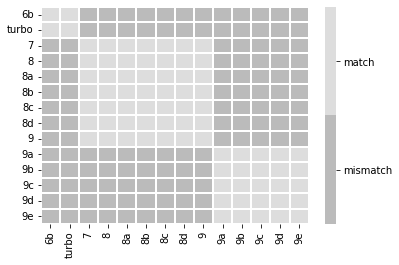

In [19]:
# create plot
fig,ax = plt.subplots(1,1)
import seaborn as sns
sns.heatmap(
    pd.DataFrame(distmat_rgb == 0, index=versions2, columns=versions2),
    linewidth=.05, ax=ax, cmap=['#BBB','#DDD'])
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / 2 * (0.5 + i) for i in range(2)])
colorbar.set_ticklabels(['mismatch','match'])
#plt.show();
plt.savefig('../text/forensic/figures/mismatch_decompression_rgb.png', dpi=100)

Mismatch matrix supports the clusters discovered before.

### Difference

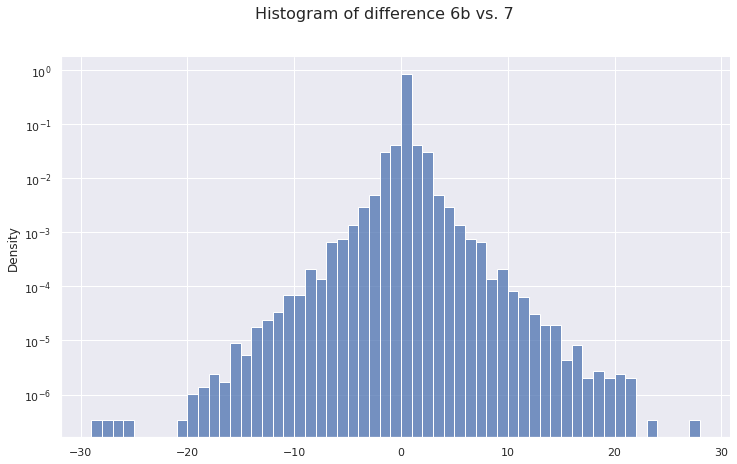

In [20]:
# difference image
(image6b,) = images_rgb[images_rgb.version == '6b'].image
(image7,) = images_rgb[images_rgb.version == '7'].image
D = (image6b.astype(np.int32) - image7.astype(np.int32))
# create histogram
sns.set_theme()
fig,ax = plt.subplots(1,1, figsize=[12,7])
sns.despine(left=False, bottom=False)
g = sns.histplot(D.flatten(), ax=ax, binwidth=1, stat='density')
g.set_yscale('log');
fig.suptitle(f'Histogram of difference 6b vs. 7', fontsize=16);

In [8]:
fig,axs = plt.subplots(1,3, figsize=(16,4), sharey=True)
for i,(ax,title) in enumerate(zip(axs.flat,['Red','Green','Blue'])):
    g = sns.histplot(D[:,:,:,i].flatten(), ax=ax, binwidth=1, stat='density')
    g.set_yscale('log');
    g.set_title(title, fontsize=12)
fig.suptitle(f'Histograms of difference 6b vs. 7', fontsize=16);

NameError: name 'plt' is not defined

In [9]:
fig,axs = plt.subplots(1,3, figsize=(16,4), sharey=True)
cbar_ax = fig.add_axes([.92, .15, .02, .7])
vmin,vmax = D.mean() - D.std(), D.mean() + D.std() # three sigma
for i,(ax,title) in enumerate(zip(axs.flat,['Red','Green','Blue'])):
    p = sns.heatmap(D[1,:,:,i], cbar=i==0, vmin=vmin, vmax=vmax,
                    cmap=sns.color_palette("icefire", as_cmap=True),
                    ax=ax, cbar_ax=None if i else cbar_ax)
    p.set_xticks([0,63,127,191,255])
    p.set_yticks([0,63,127,191,255])
    p.set_title(title, fontsize=12)
fig.suptitle(f'Difference 6b vs. 7', fontsize=16);
plt.savefig('../text/forensic/figures/diff_decompression_6b_7.png');

NameError: name 'plt' is not defined

## Grayscale images

Now we change to BOSS database, as we will work with grayscale images.

### Compression

First we decompress grayscale images.

In [10]:
# images recompressed by each version
images_gray = {'version': [], 'image': [], 'Y': []}

import tempfile
with tempfile.TemporaryDirectory() as tmp:
    
    # iterate versions
    for i,v_decompress in enumerate(versions):
        
        # compress each image with version
        fnames = [str(Path(tmp) / f'{i}.jpeg') for i in range(alaska.shape[0])]
        with jpeglib.version(v_arbitrary):
            for i,fname in enumerate(fnames):
                im = jpeglib.from_spatial(boss[i], 'JCS_GRAYSCALE')
                im.write_spatial(fname)
        
        # decompress with single (arbitrary) version
        with jpeglib.version(v_decompress):
            images_gray['version'].append(v_decompress)
            images_gray['image'].append(np.array([
                jpeglib.read_spatial(fname).spatial for fname in fnames
            ]))
            images_gray['Y'].append(np.array([
                jpeglib.read_dct(fname).Y for fname in fnames
            ]))

# dataframe
images_gray = pd.DataFrame(images_gray)

NameError: name 'alaska' is not defined

### N-to-N comparison

Then we compare all the versions and construct distance matrix.

In [40]:
# images to distance matrix
images_gray_list = np.array([list(i) for i in images_gray.image.to_list()], dtype=object)
images_gray_list = images_gray_list.reshape(len(versions), -1)
dists_gray = pdist(images_gray_list, pixel_mismatch)
distmat_gray = squareform(dists_gray)

### Clustering

The distance matrix is clustered based, so that we have uniform clusters.

In [41]:
# cluster
from sklearn.cluster import AgglomerativeClustering
for k in range(1,6):
    agnes = AgglomerativeClustering(n_clusters=k, linkage='average', affinity='precomputed')
    agnes.fit(distmat_gray)
    
    # compute heterogenity metric (sum of distances)
    heterogenity = np.sum([ distmat_gray[i,j]
             for group in np.unique(agnes.labels_)
             for i in np.where(agnes.labels_ == group)[0]
             for j in np.where(agnes.labels_ == group)[0] ])
    
    # homogenous clusters
    if heterogenity == 0: break
print(k, "classes:", *[[versions[i] for i in np.where(agnes.labels_ == cl)[0]] for cl in np.unique(agnes.labels_)])

1 classes: ['6b', 'turbo210', '7', '8', '8a', '8b', '8c', '8d', '9', '9a', '9b', '9c', '9d', '9e']


All the versions belong to the same cluster.

### Plot of mismatch matrix

For control, we again plot the mismatch matrix.

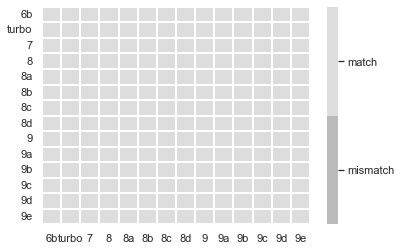

In [42]:
# create plot
fig,ax = plt.subplots(1,1)
import seaborn as sns
sns.heatmap(
    pd.DataFrame(distmat_gray == 0, index=versions2, columns=versions2),
    linewidth=.05, ax=ax, cmap=['#BBB','#DDD'])
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / 2 * (0.5 + i) for i in range(2)])
colorbar.set_ticklabels(['mismatch','match'])
plt.show();

Heatmap shows that every version's output matches with every other.